## 0 . Setup


In [704]:
%pip -q install torch torchvision torchinfo torchaudio torchmetrics pandas numpy matplotlib tqdm scikit-learn mlxtend;


[notice] A new release of pip is available: 23.1.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [705]:
import torch
import numpy as np


# Setup device agnostic code
def get_device():
    device = "cuda" if torch.cuda.is_available() else "cpu"
    device = "mps" if torch.backends.mps.is_available() else device
    return device


# Setup random seed
def seed_everything(seed=42):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True


seed_everything()
DEVICE = get_device()

## 1. Load data


In [706]:
import requests
import zipfile
from pathlib import Path

data_dir = Path("data")
img_path = data_dir / "pizza_steak_sushi"


if img_path.is_dir():
    print("Data already downloaded")
else:
    print("Downloading data...")
    img_path.mkdir(parents=True, exist_ok=True)

    with open(data_dir / "pizza_steak_sushi.zip", "wb") as f:
        r = requests.get(
            "https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip"
        )
        f.write(r.content)

    print("Unzipping data...")
    with zipfile.ZipFile(data_dir / "pizza_steak_sushi.zip", "r") as zip_ref:
        zip_ref.extractall(img_path)

    print("Data downloaded and unzipped")

Data already downloaded


## 2. Explore Data


In [707]:
import os


def walk_dir(dir_path):
    for dirpath, dirnames, filenames in os.walk(dir_path):
        print(
            f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'."
        )


walk_dir(img_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.


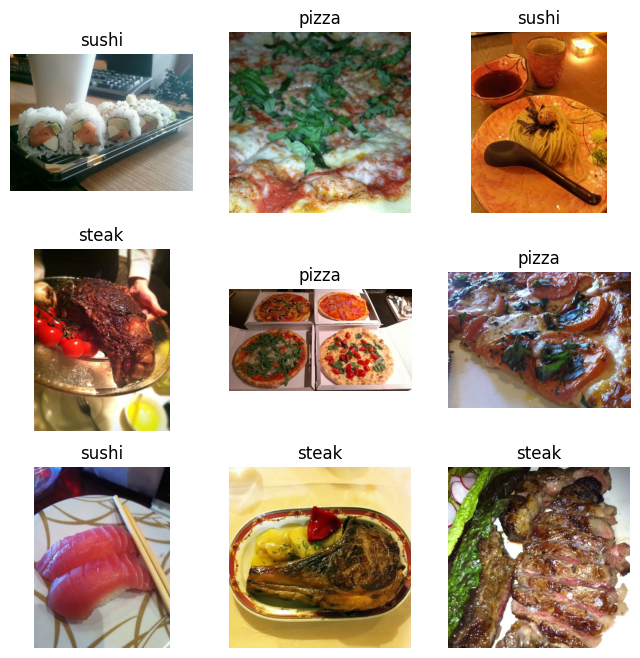

In [708]:
## Visualize data

import matplotlib.pyplot as plt
from PIL import Image


# Get all image paths
def create_image_paths(dir_path):
    image_paths = []
    for dirpath, _, filenames in os.walk(dir_path):
        for filename in filenames:
            if filename.endswith(".jpg"):
                image_paths.append(os.path.join(dirpath, filename))
    return image_paths


img_paths = create_image_paths(img_path)
n_samples = 9
sample_indices = np.random.choice(len(img_paths), n_samples, replace=False)
sample_images = [Image.open(img_paths[idx]) for idx in sample_indices]

plt.figure(figsize=(8, 8))
for i, image in enumerate(sample_images):
    label = img_paths[sample_indices[i]].split("/")[-2]
    plt.subplot(3, 3, i + 1)
    plt.imshow(image)
    plt.title(label)
    plt.axis("off")
plt.show()

## 3. Transform Data


In [709]:
from torch.utils.data import DataLoader
from torchvision import transforms

data_transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((64, 64), antialias=True),
        # random horizontal flip
        transforms.RandomHorizontalFlip(p=0.5),
    ]
)

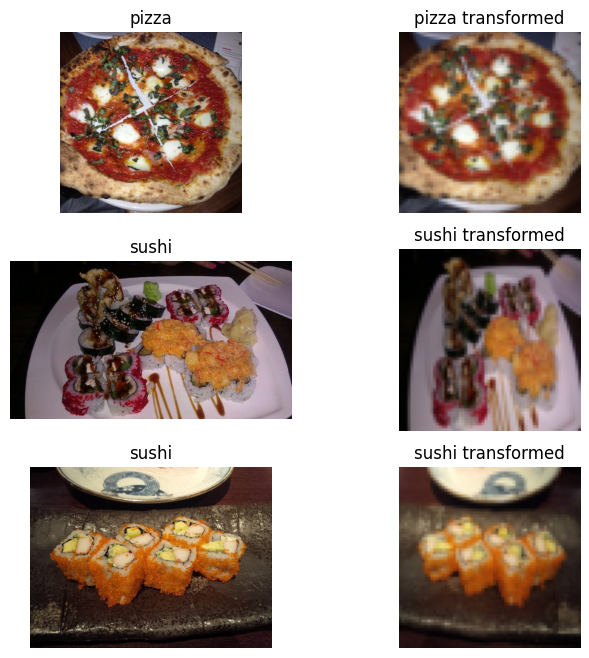

In [710]:
def plot_transformed_images(img_paths, n_samples, data_transform):
    sample_indices = np.random.choice(len(img_paths), n_samples, replace=False)
    sample_images = [Image.open(img_paths[idx]) for idx in sample_indices]

    transformed_images = [data_transform(image) for image in sample_images]

    plt.figure(figsize=(8, 8))
    k = 0
    for i, image in enumerate(sample_images):
        label = img_paths[sample_indices[i]].split("/")[-2]
        plt.subplot(n_samples, 2, k + 1)
        plt.imshow(image)
        plt.title(label)
        plt.axis("off")
        plt.subplot(n_samples, 2, k + 2)
        plt.imshow(transformed_images[i].permute(1, 2, 0))
        plt.title(label + " transformed")
        plt.axis("off")
        k += 2
    plt.show()


plot_transformed_images(img_paths, 3, data_transform)

## 4. Load Data with Image Folder


In [711]:
from torchvision.datasets import ImageFolder

train_data = ImageFolder(root=img_path / "train", transform=data_transform)
test_data = ImageFolder(root=img_path / "test", transform=data_transform)

print(f"There are {len(train_data)} images in the training dataset.")
print(f"There are {len(test_data)} images in the test dataset.")
print(f"Class Dict: {train_data.class_to_idx}")

There are 225 images in the training dataset.
There are 75 images in the test dataset.
Class Dict: {'pizza': 0, 'steak': 1, 'sushi': 2}


Shape of a sample image: torch.Size([3, 64, 64])


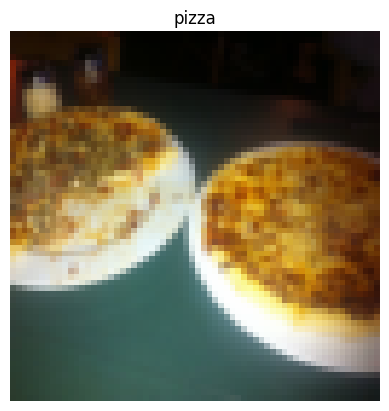

In [712]:
sample_img, sample_label = train_data[0]
print(f"Shape of a sample image: {sample_img.shape}")
plt.imshow(sample_img.permute(1, 2, 0))
plt.title(train_data.classes[sample_label])
plt.axis("off")
plt.show()

In [713]:
# Turn into dataloaders

BATCH_SIZE = 32
train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

print(f"There are {len(train_dataloader)} batches in the training dataloader.")
print(f"There are {len(test_dataloader)} batches in the test dataloader.")

There are 8 batches in the training dataloader.
There are 3 batches in the test dataloader.


In [714]:
img, label = next(iter(train_dataloader))

print(f"Shape of a batch of images: {img.shape}")
print(f"Shape of a batch of labels: {label.shape}")

Shape of a batch of images: torch.Size([32, 3, 64, 64])
Shape of a batch of labels: torch.Size([32])


## 5. Load Data with Custom Dataset


In [715]:
import os
import pathlib
import torch


from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [716]:
target_directory = data_dir / "pizza_steak_sushi" / "train"
print(f"Target directory: {target_directory}")

class_names = sorted(os.listdir(target_directory))
print(f"Class names: {class_names}")

Target directory: data/pizza_steak_sushi/train
Class names: ['pizza', 'steak', 'sushi']


In [717]:
def find_classes(directory: pathlib.Path) -> Tuple[List[str], Dict[str, int]]:
    classes = sorted(os.listdir(directory))
    classes = [item for item in classes if os.path.isdir(os.path.join(directory, item))]
    classes_to_idx = {classes[i]: i for i in range(len(classes))}
    if len(classes) == 0:
        raise FileNotFoundError(f"Couldn't find any class folders in {directory}.")
    return classes, classes_to_idx


target_directory = data_dir / "pizza_steak_sushi" / "train"
classes, classes_to_idx = find_classes(target_directory)
print(f"Classes: {classes}")
print(f"Classes to index: {classes_to_idx}")

Classes: ['pizza', 'steak', 'sushi']
Classes to index: {'pizza': 0, 'steak': 1, 'sushi': 2}


In [718]:
class ImageFolderCustom(Dataset):
    def __init__(self, target_directory: str, transform=None):
        super().__init__()
        self.target_directory = pathlib.Path(target_directory)
        self.paths = list(self.target_directory.glob("*/*.jpg"))

        self.transform = transform
        self.classes, self.class_to_idx = find_classes(self.target_directory)

    def load_image(self, index: int) -> Image.Image:
        return Image.open(self.paths[index])

    def __len__(self) -> int:
        return len(self.paths)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        image = self.load_image(index)
        label = self.class_to_idx[self.paths[index].parent.name]
        label = torch.tensor(label, dtype=torch.long)

        if self.transform:
            image = self.transform(image)
        return image, label

There are 225 images in the training dataset.
Class Dict: {'pizza': 0, 'steak': 1, 'sushi': 2}
Shape of a sample image: torch.Size([3, 64, 64])


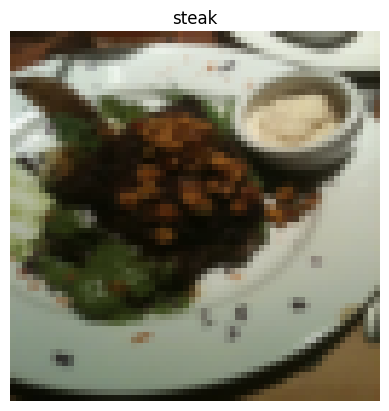

In [719]:
target_directory = data_dir / "pizza_steak_sushi" / "train"
train_data_custom = ImageFolderCustom(target_directory, transform=data_transform)

print(f"There are {len(train_data_custom)} images in the training dataset.")
print(f"Class Dict: {train_data_custom.class_to_idx}")


sample_img, sample_label = train_data_custom[0]
print(f"Shape of a sample image: {sample_img.shape}")
plt.imshow(sample_img.permute(1, 2, 0))
plt.title(train_data_custom.classes[sample_label])
plt.axis("off")
plt.show()

In [720]:
# Checking if the custom dataset is the same as the PyTorch dataset

classes_are_same = train_data_custom.classes == train_data.classes
class_to_idx_are_same = train_data_custom.class_to_idx == train_data.class_to_idx
print(f"Classes are the same: {classes_are_same}")
print(f"Class to idx are the same: {class_to_idx_are_same}")

Classes are the same: True
Class to idx are the same: True


In [721]:
from torch.utils.data import DataLoader


BATCH_SIZE = 32
train_dataloader_custom = DataLoader(
    train_data_custom, batch_size=BATCH_SIZE, shuffle=True
)

test_dir = data_dir / "pizza_steak_sushi" / "test"
test_data_custom = ImageFolderCustom(test_dir, transform=data_transform)
test_dataloader_custom = DataLoader(
    test_data_custom, batch_size=BATCH_SIZE, shuffle=False
)

In [722]:
img_custom, label = next(iter(train_dataloader_custom))

print(f"Shape of image: {img_custom.shape}")
print(f"Shape of label: {label.shape}")

Shape of image: torch.Size([32, 3, 64, 64])
Shape of label: torch.Size([32])


## 6. Data Augmentation


In [723]:
from torchvision import transforms

train_transform = transforms.Compose(
    [
        transforms.Resize((224, 224), antialias=True),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224), antialias=True),
        transforms.ToTensor(),
    ]
)

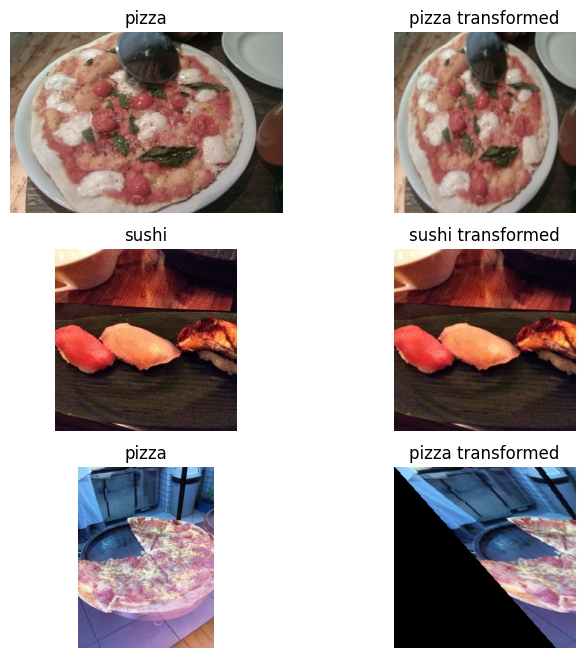

In [724]:
img_path = data_dir / "pizza_steak_sushi"
img_paths = create_image_paths(img_path)
plot_transformed_images(img_paths, 3, train_transform)

## 7. Model without Data Augmentation

In [725]:
simple_transform = transforms.Compose(
    [
        transforms.Resize((64, 64), antialias=True),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_dir = Path("data/pizza_steak_sushi/train")
test_dir = Path("data/pizza_steak_sushi/test")
train_data_simple = ImageFolder(train_dir, transform=simple_transform)
test_data_simple = ImageFolder(test_dir, transform=simple_transform)

BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_simple = DataLoader(
    train_data_simple, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
test_dataloader_simple = DataLoader(
    test_data_simple, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [726]:
from torch import nn


class TinyVGG(nn.Module):
    def __init__(self, input_shape, hidden_channels, num_classes):
        super().__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=input_shape,
                out_channels=hidden_channels,
                kernel_size=3,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                padding=0,
            ),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_channels,
                out_channels=hidden_channels,
                kernel_size=3,
                padding=0,
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Flatten(), nn.Linear(hidden_channels * 13 * 13, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        y = self.classifier(x)
        return y

In [727]:
DEVICE = get_device()
n_classes = len(train_data_simple.classes)
model = TinyVGG(input_shape=3, hidden_channels=10, num_classes=n_classes).to(DEVICE)

In [728]:
# Sanity check
sample_input, sample_label = next(iter(train_dataloader_simple))
sample_input = sample_input.to(DEVICE)
sample_output = model(sample_input)
print(f"Sample input shape: {sample_input.shape}")
print(f"Sample output shape: {sample_output.shape}")

Sample input shape: torch.Size([32, 3, 64, 64])
Sample output shape: torch.Size([32, 3])


In [729]:
# torch info for model
from torchinfo import summary

summary(model, input_size=(BATCH_SIZE, 3, 64, 64))

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [32, 3]                   --
├─Sequential: 1-1                        [32, 10, 30, 30]          --
│    └─Conv2d: 2-1                       [32, 10, 62, 62]          280
│    └─ReLU: 2-2                         [32, 10, 62, 62]          --
│    └─Conv2d: 2-3                       [32, 10, 60, 60]          910
│    └─ReLU: 2-4                         [32, 10, 60, 60]          --
│    └─MaxPool2d: 2-5                    [32, 10, 30, 30]          --
├─Sequential: 1-2                        [32, 10, 13, 13]          --
│    └─Conv2d: 2-6                       [32, 10, 28, 28]          910
│    └─ReLU: 2-7                         [32, 10, 28, 28]          --
│    └─Conv2d: 2-8                       [32, 10, 26, 26]          910
│    └─ReLU: 2-9                         [32, 10, 26, 26]          --
│    └─MaxPool2d: 2-10                   [32, 10, 13, 13]          --
├─Sequentia

## 8. Training

In [730]:
def train_step(model, dataloader, loss_fn, optimzer, device):
    model.to(device)
    model.train()
    train_loss = 0.0
    train_acc = 0.0

    for X, Y in dataloader:
        X, Y = X.to(device), Y.to(device)

        Y_pred = model(X)
        Y_pred_classes = torch.argmax(torch.softmax(Y_pred, dim=1), dim=1)
        loss = loss_fn(Y_pred, Y)
        acc = torch.sum(Y_pred_classes == Y) / len(Y)

        train_loss += loss
        train_acc += acc

        optimzer.zero_grad()
        loss.backward()
        optimzer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)
    print(f"Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f}")
    return train_loss, train_acc * 100


def test_step(model, dataloader, loss_fn, device):
    model.to(device)
    model.eval()

    test_loss, test_acc = 0.0, 0.0
    with torch.inference_mode():
        for X, Y in dataloader:
            X, Y = X.to(device), Y.to(device)

            Y_pred = model(X)
            Y_pred_classes = torch.argmax(torch.softmax(Y_pred, dim=1), dim=1)
            loss = loss_fn(Y_pred, Y)
            acc = torch.sum(Y_pred_classes == Y) / len(Y)

            test_loss += loss
            test_acc += acc

        test_loss /= len(dataloader)
        test_acc /= len(dataloader)
        print(f"Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}")

    return test_loss, test_acc * 100

In [731]:
def train(model, epochs, loss_fn, optimizer, train_dataloader, test_dataloader, device):
    history = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        print("-" * 20)
        train_loss, train_acc = train_step(
            model, train_dataloader, loss_fn, optimizer, device
        )
        test_loss, test_acc = test_step(model, test_dataloader, loss_fn, device)

        history["train_loss"].append(train_loss.item())
        history["train_acc"].append(train_acc.item())
        history["test_loss"].append(test_loss.item())
        history["test_acc"].append(test_acc.item())

        print(
            f"Epoch {epoch + 1} | Train loss: {train_loss:.3f} | Train acc: {train_acc:.3f} | Test loss: {test_loss:.3f} | Test acc: {test_acc:.3f}"
        )

    return history

In [732]:
epochs = 12
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = train(
    model,
    epochs,
    loss_fn,
    optimizer,
    train_dataloader_simple,
    test_dataloader_simple,
    DEVICE,
)

Epoch 1/12
--------------------
Train loss: 1.095 | Train acc: 0.410
Test loss: 1.121 | Test acc: 0.260
Epoch 1 | Train loss: 1.095 | Train acc: 41.016 | Test loss: 1.121 | Test acc: 26.042
Epoch 2/12
--------------------
Train loss: 1.075 | Train acc: 0.426
Test loss: 1.120 | Test acc: 0.281
Epoch 2 | Train loss: 1.075 | Train acc: 42.578 | Test loss: 1.120 | Test acc: 28.125
Epoch 3/12
--------------------
Train loss: 1.062 | Train acc: 0.398
Test loss: 1.092 | Test acc: 0.301
Epoch 3 | Train loss: 1.062 | Train acc: 39.844 | Test loss: 1.092 | Test acc: 30.114
Epoch 4/12
--------------------
Train loss: 0.960 | Train acc: 0.625
Test loss: 0.988 | Test acc: 0.526
Epoch 4 | Train loss: 0.960 | Train acc: 62.500 | Test loss: 0.988 | Test acc: 52.557
Epoch 5/12
--------------------
Train loss: 0.972 | Train acc: 0.508
Test loss: 1.008 | Test acc: 0.442
Epoch 5 | Train loss: 0.972 | Train acc: 50.781 | Test loss: 1.008 | Test acc: 44.223
Epoch 6/12
--------------------
Train loss: 0.800 

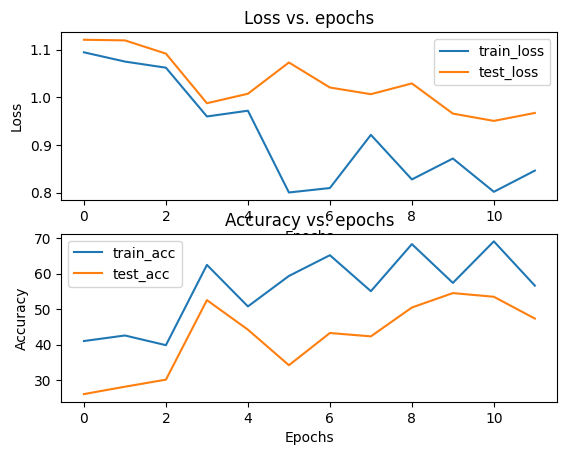

In [733]:
# plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.title("Loss vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# plot accuracy
plt.subplot(2, 1, 2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.title("Accuracy vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

## 9. Model with Data Augmentation

In [734]:
better_transform = transforms.Compose(
    [
        transforms.Resize((64, 64), antialias=True),
        transforms.TrivialAugmentWide(),
        transforms.ToTensor(),
        transforms.Normalize((0.5), (0.5)),
    ]
)

test_transforms = transforms.Compose(
    [
        transforms.Resize((64, 64), antialias=True),
        transforms.ToTensor(),
    ]
)

train_data_better = ImageFolder(train_dir, transform=better_transform)
test_data_better = ImageFolder(test_dir, transform=better_transform)

BATCH_SIZE = 32
NUM_WORKERS = 0
train_dataloader_better = DataLoader(
    train_data_better, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)
test_dataloader_better = DataLoader(
    test_data_better, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

In [735]:
model = TinyVGG(input_shape=3, hidden_channels=64, num_classes=n_classes).to(DEVICE)

In [736]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 12
history = train(
    model,
    epochs,
    loss_fn,
    optimizer,
    train_dataloader_better,
    test_dataloader_better,
    DEVICE,
)

Epoch 1/12
--------------------
Train loss: 1.069 | Train acc: 0.418
Test loss: 1.142 | Test acc: 0.260
Epoch 1 | Train loss: 1.069 | Train acc: 41.797 | Test loss: 1.142 | Test acc: 26.042
Epoch 2/12
--------------------
Train loss: 1.122 | Train acc: 0.363
Test loss: 1.112 | Test acc: 0.229
Epoch 2 | Train loss: 1.122 | Train acc: 36.328 | Test loss: 1.112 | Test acc: 22.917
Epoch 3/12
--------------------
Train loss: 1.076 | Train acc: 0.441
Test loss: 1.100 | Test acc: 0.279
Epoch 3 | Train loss: 1.076 | Train acc: 44.141 | Test loss: 1.100 | Test acc: 27.936
Epoch 4/12
--------------------
Train loss: 1.066 | Train acc: 0.363
Test loss: 1.105 | Test acc: 0.414
Epoch 4 | Train loss: 1.066 | Train acc: 36.328 | Test loss: 1.105 | Test acc: 41.383
Epoch 5/12
--------------------
Train loss: 1.045 | Train acc: 0.484
Test loss: 1.007 | Test acc: 0.494
Epoch 5 | Train loss: 1.045 | Train acc: 48.438 | Test loss: 1.007 | Test acc: 49.432
Epoch 6/12
--------------------
Train loss: 0.975 

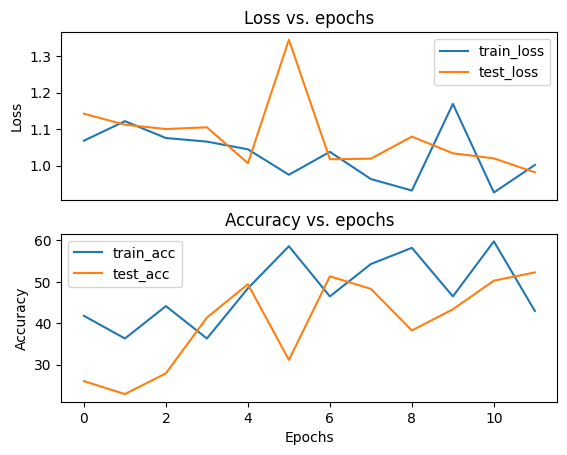

In [739]:
# plot loss
plt.subplot(2, 1, 1)
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["test_loss"], label="test_loss")
plt.title("Loss vs. epochs")
plt.ylabel("Loss")
plt.xticks([])
plt.legend()

# plot accuracy
plt.subplot(2, 1, 2)
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["test_acc"], label="test_acc")
plt.title("Accuracy vs. epochs")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.show()